In [ ]:
#American Electric Power (AEP)***
#CommonWealth Edison (ComEd)
#The Dayton Power and Light Company (DAYTON)
#Duke Energy Ohio/Kentucky (DEOK)
#Dominion Virginia Power (DOM)
#Duquesne Light Co. (DUQ)
#East kentucky Power Cooperative (EKPC)
#First Energy (FE)
#Northern Illinois Hub (IN)
#PJM East region: 2001-2018 (PJME)
#PJM West Region: 2001-2018 (PJMW)
#PJM Load Combined: 1998-2001 (PJM_load)




from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
plt.style.use('ggplot')



dataset_identifier = "robikscube/hourly-energy-consumption"

from google.colab import drive
drive.mount("/content/drive")

kaggle_creds_path = "/content/drive/My Drive/Dataset/kaggle.json"

! pip install kaggle --quiet

! mkdir ~/.kaggle
! cp "{kaggle_creds_path}" ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json

! kaggle datasets download -d {dataset_identifier}

! mkdir kaggle_data
! unzip "{dataset_identifier.split('/')[-1]}.zip" -d kaggle_data

drive.flush_and_unmount()



Mounted at /content/drive
Dataset URL: https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption
License(s): CC0-1.0
 79% 9.00M/11.4M [00:00<00:00, 43.3MB/s]
100% 11.4M/11.4M [00:00<00:00, 52.3MB/s]
Archive:  hourly-energy-consumption.zip
  inflating: kaggle_data/AEP_hourly.csv  
  inflating: kaggle_data/COMED_hourly.csv  
  inflating: kaggle_data/DAYTON_hourly.csv  
  inflating: kaggle_data/DEOK_hourly.csv  
  inflating: kaggle_data/DOM_hourly.csv  
  inflating: kaggle_data/DUQ_hourly.csv  
  inflating: kaggle_data/EKPC_hourly.csv  
  inflating: kaggle_data/FE_hourly.csv  
  inflating: kaggle_data/NI_hourly.csv  
  inflating: kaggle_data/PJME_hourly.csv  
  inflating: kaggle_data/PJMW_hourly.csv  
  inflating: kaggle_data/PJM_Load_hourly.csv  
  inflating: kaggle_data/est_hourly.paruqet  
  inflating: kaggle_data/pjm_hourly_est.csv  


In [ ]:
df = pd.read_csv('/content/kaggle_data/AEP_hourly.csv')
df.dataframeName = 'AEP_hourly.csv'

df.head()

,Datetime,AEP_MW
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0
2,2004-12-31 03:00:00,12577.0
3,2004-12-31 04:00:00,12517.0
4,2004-12-31 05:00:00,12670.0


In [ ]:
df.describe()

,AEP_MW
count,121273.000000
mean,15499.513717
std,2591.399065
min,9581.000000
25%,13630.000000
50%,15310.000000
75%,17200.000000
max,25695.000000


In [ ]:
df['Datetime'] = pd.to_datetime(df['Datetime'])
df.set_index('Datetime', inplace=True)

In [ ]:
df = df.sort_index()
filtered_df = df.loc['2017-01-01':'2017-12-31']

print(filtered_df.head())
print(filtered_df.tail())

                      AEP_MW
Datetime                    
2017-01-01 00:00:00  13240.0
2017-01-01 01:00:00  12876.0
2017-01-01 02:00:00  12591.0
2017-01-01 03:00:00  12487.0
2017-01-01 04:00:00  12369.0
                      AEP_MW
Datetime                    
2017-12-31 19:00:00  19608.0
2017-12-31 20:00:00  19442.0
2017-12-31 21:00:00  19323.0
2017-12-31 22:00:00  19092.0
2017-12-31 23:00:00  18877.0


In [ ]:
train = filtered_df.loc['2017-01-01':'2017-09-30']
test = filtered_df.loc['2017-10-01':'2017-12-31']


print("Training Set Preview:")
print(train.head())
print("\nTesting Set Preview:")
print(test.head())

Training Set Preview:
                      AEP_MW
Datetime                    
2017-01-01 00:00:00  13240.0
2017-01-01 01:00:00  12876.0
2017-01-01 02:00:00  12591.0
2017-01-01 03:00:00  12487.0
2017-01-01 04:00:00  12369.0

Testing Set Preview:
                      AEP_MW
Datetime                    
2017-10-01 00:00:00  10948.0
2017-10-01 01:00:00  10460.0
2017-10-01 02:00:00  10060.0
2017-10-01 03:00:00   9960.0
2017-10-01 04:00:00   9835.0


In [ ]:
from sklearn.preprocessing import MinMaxScaler


scaler = MinMaxScaler()

train_scaled = scaler.fit_transform(train[['AEP_MW']])
test_scaled = scaler.transform(test[['AEP_MW']])

train_scaled = pd.DataFrame(train_scaled, columns=['AEP_MW'], index=train.index)
test_scaled = pd.DataFrame(test_scaled, columns=['AEP_MW'], index=test.index)

print("Scaled Training Set Preview:")
print(train_scaled.head())
print("\nScaled Testing Set Preview:")
print(test_scaled.head())


Scaled Training Set Preview:
                       AEP_MW
Datetime                     
2017-01-01 00:00:00  0.295659
2017-01-01 01:00:00  0.265275
2017-01-01 02:00:00  0.241486
2017-01-01 03:00:00  0.232805
2017-01-01 04:00:00  0.222955

Scaled Testing Set Preview:
                       AEP_MW
Datetime                     
2017-10-01 00:00:00  0.104341
2017-10-01 01:00:00  0.063606
2017-10-01 02:00:00  0.030217
2017-10-01 03:00:00  0.021870
2017-10-01 04:00:00  0.011436


In [ ]:
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(n_steps, len(data)):
        X.append(data[i-n_steps:i, 0])  # get input
        y.append(data[i, 0])           # predict (Target value)
    return np.array(X), np.array(y)

n_steps = 24  # im using 24 hours here because this will be much better

X_train, y_train = create_sequences(train_scaled.values, n_steps)
X_test, y_test = create_sequences(test_scaled.values, n_steps)

# Reshape CNN
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


In [ ]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten
from keras.layers import Dense

model_cnn = Sequential()
model_cnn.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_steps, 1)))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(50, activation='relu'))
model_cnn.add(Dense(1))
model_cnn.compile(optimizer='adam', loss='mse')

model_cnn.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 22, 64)              │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 11, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 704)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 50)                  │          35,250 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 35,557 (138.89 KB)

 Trainable params: 35,557 (138.89 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error


model_cnn.fit(X_train, y_train, epochs=20, batch_size=32)

y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))
predicted_values_cnn = model_cnn.predict(X_test)
predicted_values_cnn = scaler.inverse_transform(predicted_values_cnn)

mse_cnn = mean_squared_error(y_test_original, predicted_values_cnn)
rmse_cnn = sqrt(mse_cnn)
mae_cnn = mean_absolute_error(y_test_original, predicted_values_cnn)
mape_cnn = mean_absolute_percentage_error(y_test_original, predicted_values_cnn)

print(f'CNN Model - Mean Squared Error: {mse_cnn}')
print(f'CNN Model - Root Mean Squared Error: {rmse_cnn}')
print(f'CNN Model - Mean Absolute Error: {mae_cnn}')
print(f'CNN Model - Mean Absolute Percentage Error: {mape_cnn}%')


Epoch 1/20
204/204 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.0247
Epoch 2/20
204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0017
Epoch 3/20
204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0011
Epoch 4/20
204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 8.9654e-04
Epoch 5/20
204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 7.7588e-04
Epoch 6/20
204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.5773e-04
Epoch 7/20
204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.6091e-04
Epoch 8/20
204/204 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 5.6489e-04
Epoch 9/20
204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.4251e-04
Epoch 10/20
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.3882e-04
Epoch 11/20
204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5.5633e-04
Epoch 12/20
204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4.8729e-04
Epoch 13/20
204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4.6784e-04
Epoch 14/20
204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.0824e-04
Epoch 15/20
2

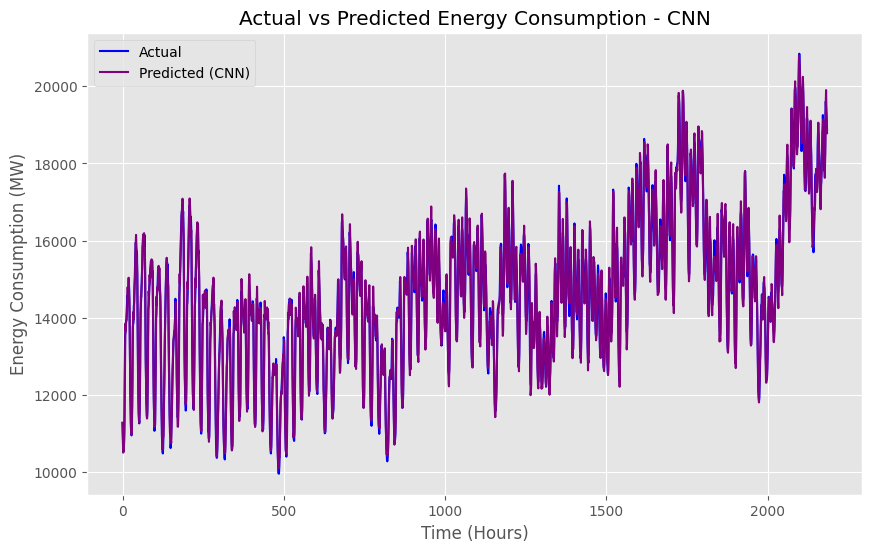

In [ ]:
plt.figure(figsize=(10, 6)) #(2208 hours)
plt.plot(y_test_original, label='Actual', color='blue')
plt.plot(predicted_values_cnn, label='Predicted (CNN)', color='purple')
plt.title('Actual vs Predicted Energy Consumption - CNN')
plt.xlabel('Time (Hours)')
plt.ylabel('Energy Consumption (MW)')
plt.legend()
plt.show()



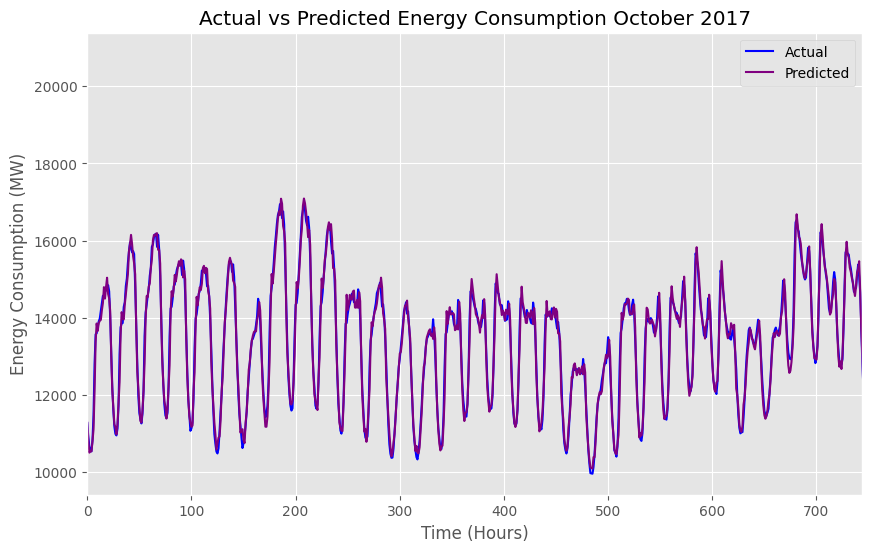

In [ ]:
# MONTH 1 (October)

plt.figure(figsize=(10, 6))
plt.plot(y_test_original, label='Actual', color='blue', linestyle='solid')
plt.plot(predicted_values_cnn, label='Predicted', color='purple', linestyle= 'solid')
plt.title('Actual vs Predicted Energy Consumption October 2017')
plt.xlabel('Time (Hours)')
plt.ylabel('Energy Consumption (MW)')
plt.legend()
plt.xlim(0, 744)
plt.show()


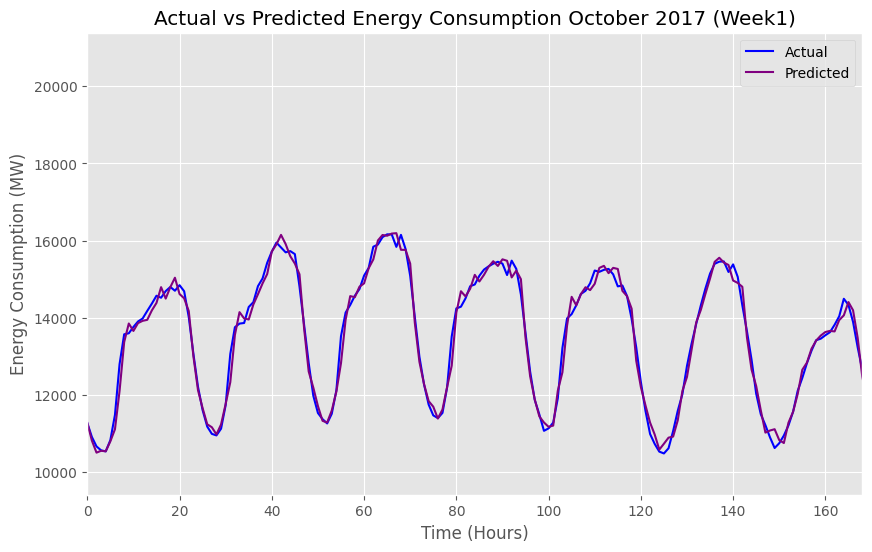

In [ ]:
# Month October week 1

plt.figure(figsize=(10, 6))
plt.plot(y_test_original, label='Actual', color='blue')
plt.plot(predicted_values_cnn, label='Predicted', color='purple')
plt.title('Actual vs Predicted Energy Consumption October 2017 (Week1)')
plt.xlabel('Time (Hours)')
plt.ylabel('Energy Consumption (MW)')
plt.legend()
plt.xlim(0, 168)
plt.show()


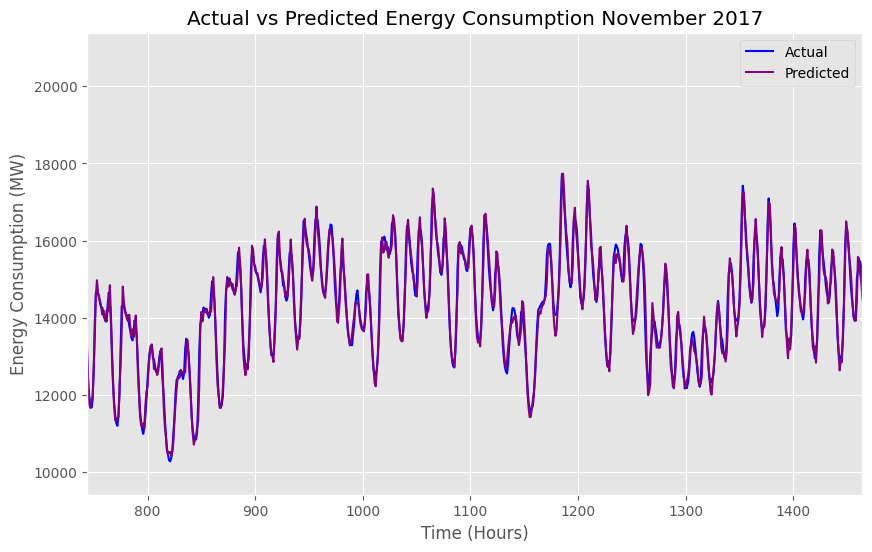

In [ ]:
# MoNTH 2 (November)

plt.figure(figsize=(10, 6))
plt.plot(y_test_original, label='Actual', color='blue')
plt.plot(predicted_values_cnn, label='Predicted', color='purple')
plt.title('Actual vs Predicted Energy Consumption November 2017')
plt.xlabel('Time (Hours)')
plt.ylabel('Energy Consumption (MW)')
plt.legend()
plt.xlim(744, 1464)
plt.show()


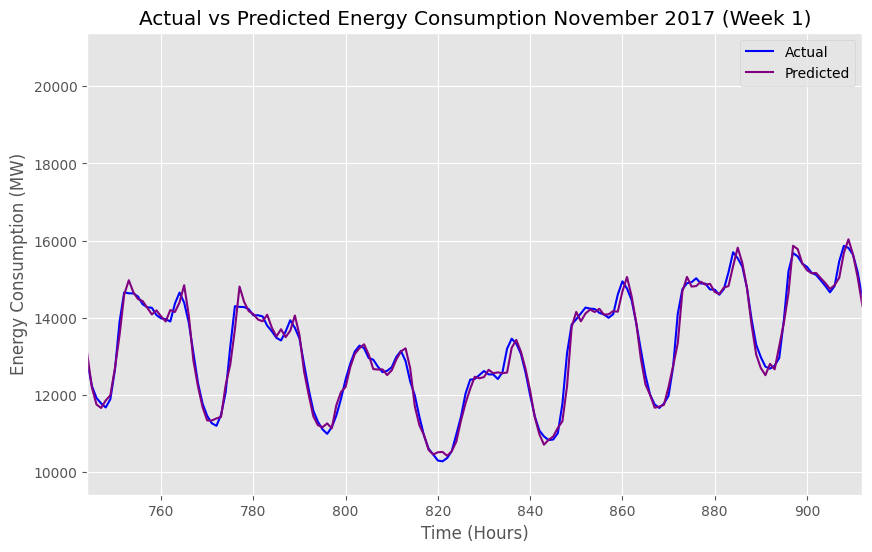

In [ ]:
# MoNTH 2 (November) Week 1

plt.figure(figsize=(10, 6))
plt.plot(y_test_original, label='Actual', color='blue')
plt.plot(predicted_values_cnn, label='Predicted', color='purple')
plt.title('Actual vs Predicted Energy Consumption November 2017 (Week 1)')
plt.xlabel('Time (Hours)')
plt.ylabel('Energy Consumption (MW)')
plt.legend()
plt.xlim(744, 912)
plt.show()


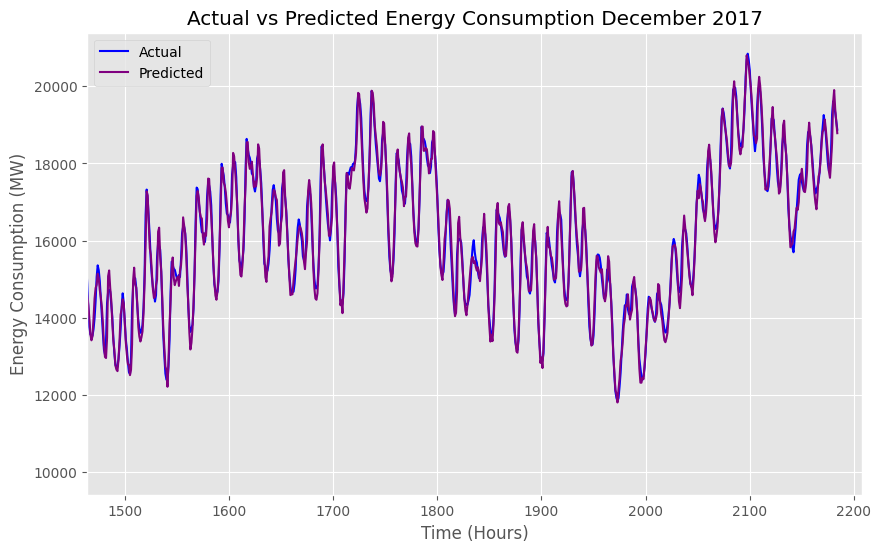

In [ ]:
# MONTH 3 (December)

plt.figure(figsize=(10, 6))
plt.plot(y_test_original, label='Actual', color='blue')
plt.plot(predicted_values_cnn, label='Predicted', color='purple')
plt.title('Actual vs Predicted Energy Consumption December 2017')
plt.xlabel('Time (Hours)')
plt.ylabel('Energy Consumption (MW)')
plt.legend()
plt.xlim(1464,2208)
plt.show()


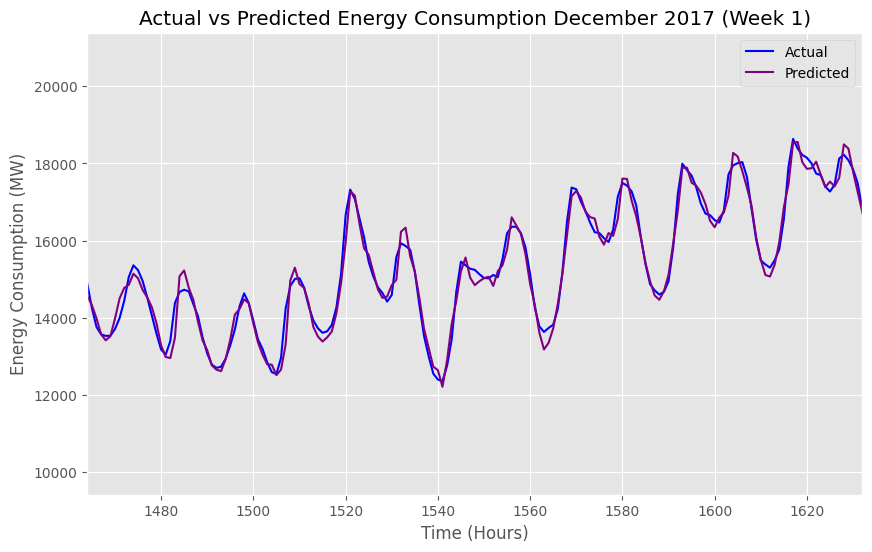

In [ ]:
# MONTH 3 (December) Week 1

plt.figure(figsize=(10, 6))
plt.plot(y_test_original, label='Actual', color='blue')
plt.plot(predicted_values_cnn, label='Predicted', color='purple')
plt.title('Actual vs Predicted Energy Consumption December 2017 (Week 1)')
plt.xlabel('Time (Hours)')
plt.ylabel('Energy Consumption (MW)')
plt.legend()
plt.xlim(1464,1632)
plt.show()


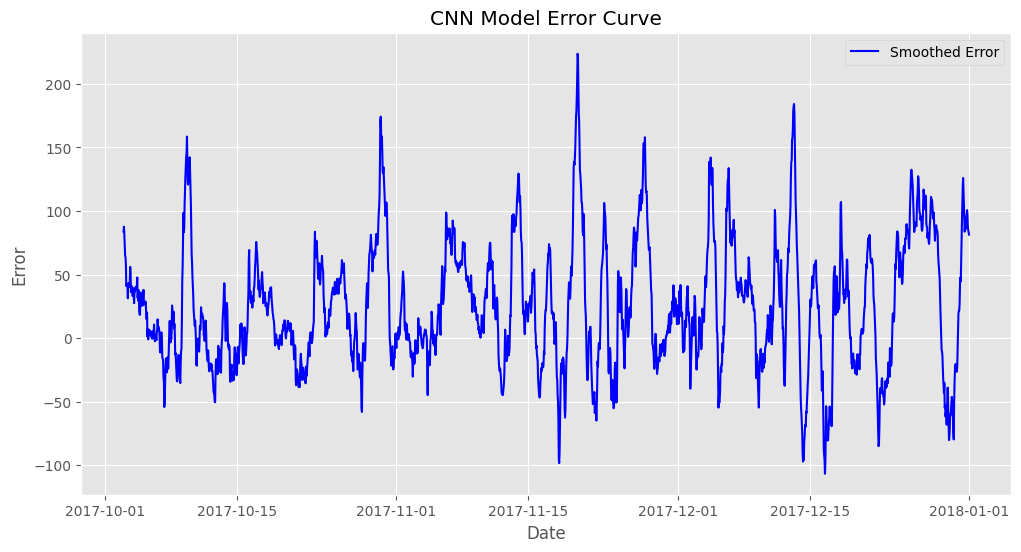

In [ ]:
errors_cnn = y_test_original.flatten() - predicted_values_cnn.flatten()


error_df_cnn = pd.DataFrame({
    'Datetime': test.index[n_steps:],
    'Error': errors_cnn
})


error_df_cnn['Smoothed_Error'] = error_df_cnn['Error'].rolling(window=24).mean()


plt.figure(figsize=(12, 6))
plt.plot(error_df_cnn['Datetime'], error_df_cnn['Smoothed_Error'], label='Smoothed Error', color='blue')
plt.xlabel('Date')
plt.ylabel('Error')
plt.title('CNN Model Error Curve')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
errors_cnn = y_test_original.flatten() - predicted_values_cnn.flatten()


results_df_cnn = pd.DataFrame({
    'timestamp': test.index[n_steps:],
    'original_values': y_test_original.flatten(),
    'CNN_predicted_values': predicted_values_cnn.flatten(),
    'CNN_errors': errors_cnn
})


results_df_cnn['CNN_smoothed_errors'] = results_df_cnn['CNN_errors'].rolling(window=24).mean()


drive.mount('/content/drive')
results_path_cnn = '/content/drive/My Drive/CNN_model_predictions.csv'
if os.path.exists(results_path_cnn):
    existing_results_df_cnn = pd.read_csv(results_path_cnn)
    updated_results_df_cnn = pd.concat([existing_results_df_cnn, results_df_cnn], ignore_index=True)
    updated_results_df_cnn.to_csv(results_path_cnn, index=False)
else:
    results_df_cnn.to_csv(results_path_cnn, index=False)
drive.flush_and_unmount()

Mounted at /content/drive
